# Deep learning examples

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/NN_examples.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebooks contains examples with neural network models.

**Table of Contents**

* [Creating TSDataset](#chapter1)  
* [Architecture](#chapter2)
* [Testing models](#chapter3)
    * [DeepAR](#section_3_1)
    * [TFT](#section_3_2)
    * [Simple Model](#section_3_3)
* [Etna native deep models](#chapter4)

In [1]:
import torch
import random

import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel

import warnings


def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


warnings.filterwarnings("ignore")

## 1. Creating TSDataset <a class="anchor" id="chapter1"></a>

We are going to take some toy dataset. Let's load and look at it.

In [2]:
original_df = pd.read_csv("data/example_dataset.csv")
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


Our library works with the special data structure TSDataset. Let's create it as it was done in "Get started" notebook.

In [3]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq="D")
ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


## 2. Architecture <a class="anchor" id="chapter2"></a>

Our library uses [PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) to work with time series neural networks.
There are two ways to use `pytorch-forecasting` models: default one and via using `PytorchForecastingDatasetBuilder` for using extra features. 

To include extra features we use `PytorchForecastingDatasetBuilder` class.

Let's look at it closer.

In [4]:
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

In [5]:
?PytorchForecastingDatasetBuilder

We can see a pretty scary signature, but don't panic, we will look at the most important parameters. 

* `time_varying_known_reals` &mdash; known real values that change across the time (real regressors), now it it necessary to add "time_idx" variable to the list;
* `time_varying_unknown_reals` &mdash; our real value target, set it to `["target"]`;
* `max_prediction_length` &mdash; our horizon for forecasting;
* `max_encoder_length` &mdash; length of past context to use;
* `static_categoricals` &mdash; static categorical values, for example, if we use multiple segments it can be some its characteristics including identifier: "segment";
* `time_varying_known_categoricals` &mdash; known categorical values that change across the time (categorical regressors);
* `target_normalizer` &mdash; class for normalization targets across different segments.

Our library currently supports these models:
* [DeepAR](https://arxiv.org/abs/1704.04110),
* [TFT](https://arxiv.org/abs/1912.09363).

## 3. Testing models <a class="anchor" id="chapter3"></a>

In this section we will test our models on example.

### 3.1 DeepAR <a class="anchor" id="section_3_1"></a>

Before training let's fix seeds for reproducibility.

In [6]:
set_seed()

#### Default way

In [7]:
from etna.models.nn import DeepARModel

HORIZON = 7


model_deepar = DeepARModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(model=model_deepar, horizon=HORIZON)

In [8]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [9]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,11.458003,10.746780,58.296696,0
0,segment_a,3.176028,3.188012,16.515891,1
0,segment_a,7.292190,7.075453,38.055756,2
3,segment_b,8.014092,7.647167,20.117558,0
3,segment_b,4.404586,4.387303,10.633235,1
3,segment_b,5.720607,6.126164,13.026143,2
1,segment_c,6.136990,6.092246,10.315199,0
1,segment_c,4.311422,4.218119,7.638397,1
1,segment_c,9.405851,9.125047,16.484022,2
2,segment_d,5.807083,5.653968,50.962106,0


To summarize it we will take mean value of SMAPE metric because it is scale tolerant.

In [10]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 6.184


#### Dataset Builder: creating dataset for DeepAR with etxtra features.

In [11]:
from pytorch_forecasting.data import GroupNormalizer

set_seed()

HORIZON = 7

transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"] + lag_columns,
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

Now we are going to start backtest.

In [12]:
from etna.models.nn import DeepARModel


model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)
metrics = [SMAPE(), MAPE(), MAE()]

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [13]:
metrics_deepar, forecast_deepar, fold_info_deepar = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.6min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Let's compare results across different segments.

In [14]:
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,6.352869,6.129627,32.770220,0
0,segment_a,3.673939,3.631979,18.586190,1
0,segment_a,4.346741,4.239818,23.106293,2
3,segment_b,6.138560,5.955818,15.267419,0
3,segment_b,3.833563,3.768379,9.465275,1
3,segment_b,3.281513,3.298270,7.616302,2
1,segment_c,5.416998,5.287060,9.203807,0
1,segment_c,5.808150,5.624208,10.211833,1
1,segment_c,5.375506,5.229224,9.724481,2
2,segment_d,5.030111,4.966043,41.805071,0


To summarize it we will take mean value of SMAPE metric because it is scale tolerant.

In [15]:
score = metrics_deepar["SMAPE"].mean()
print(f"Average SMAPE for DeepAR: {score:.3f}")

Average SMAPE for DeepAR: 4.713


Visualize results.

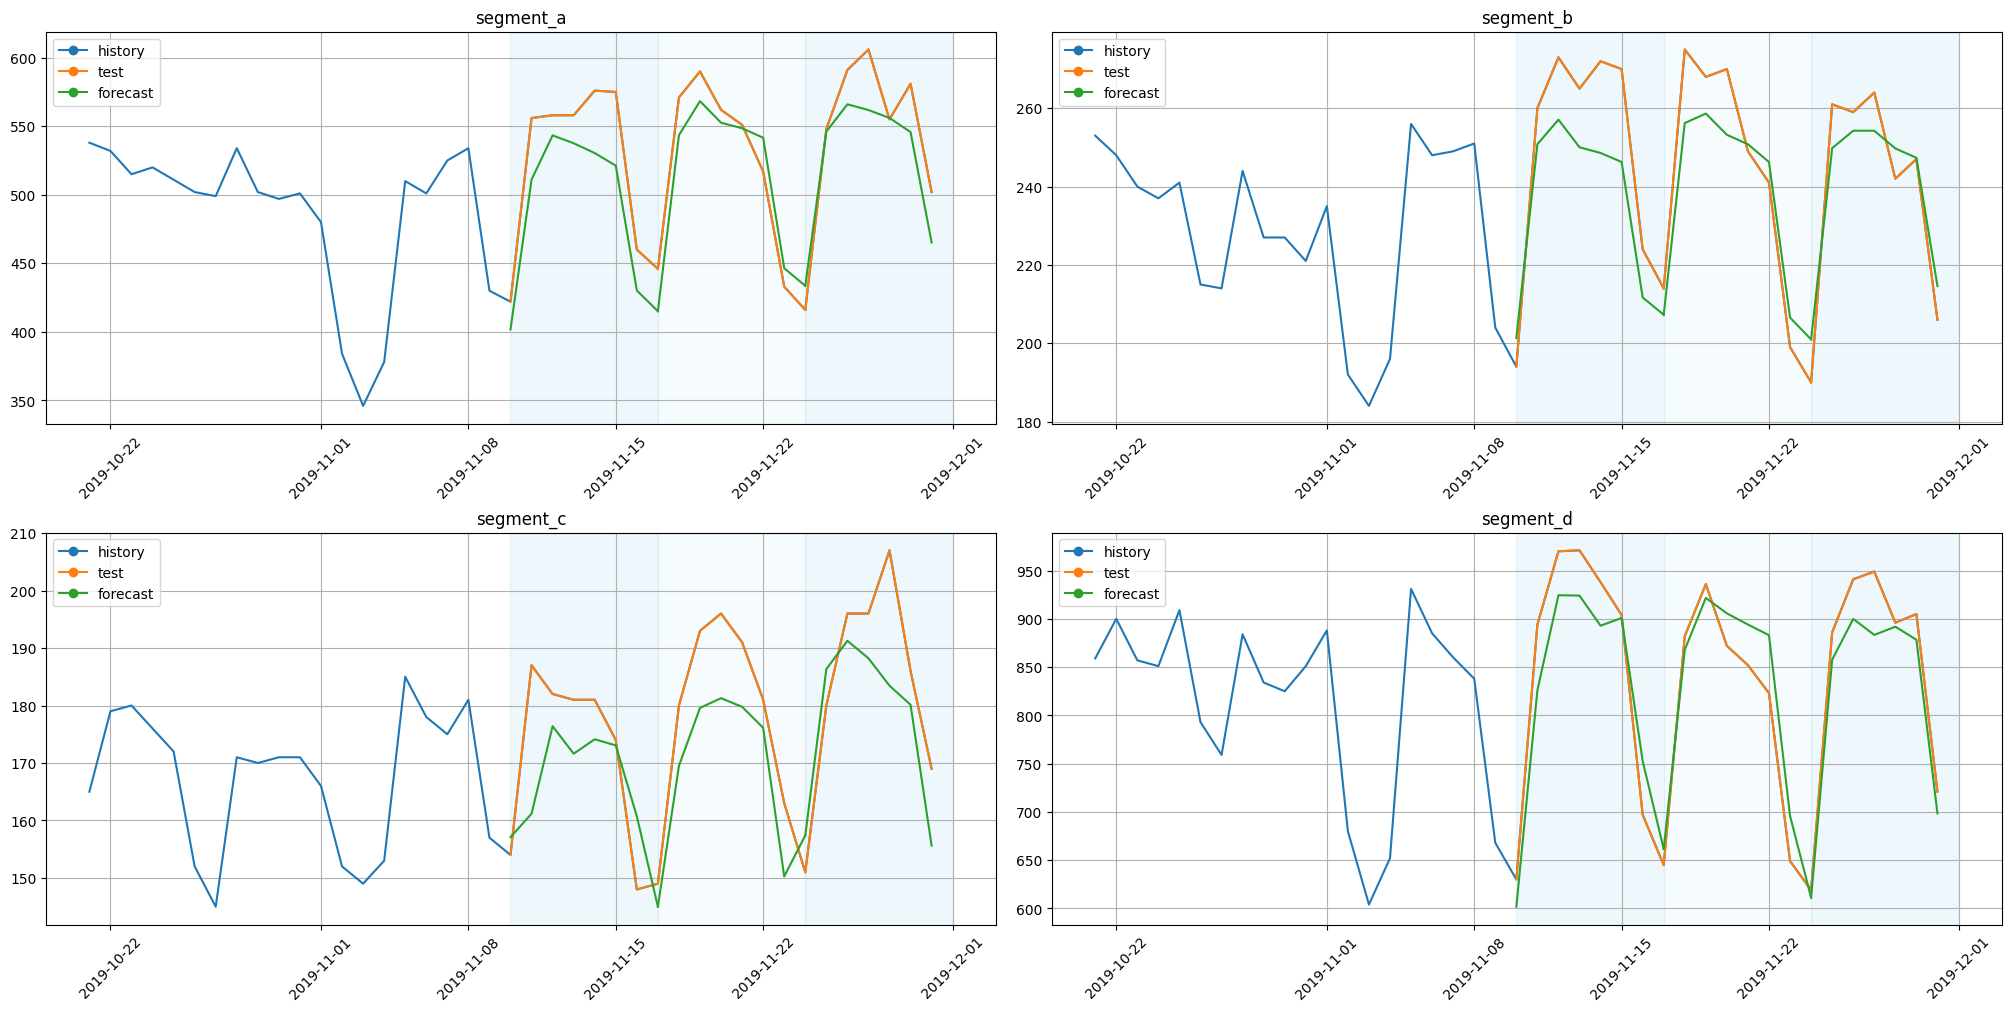

In [16]:
plot_backtest(forecast_deepar, ts, history_len=20)

### 3.2 TFT <a class="anchor" id="section_3_2"></a>

Let's move to the next model.

In [17]:
set_seed()

#### Default way

In [18]:
from etna.models.nn import TFTModel

model_tft = TFTModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
)

In [19]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_contex

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSel

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.5min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSel

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 12.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [20]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,41.527952,34.017107,184.644741,0
0,segment_a,8.790662,8.873269,45.135646,1
0,segment_a,7.237774,7.172966,38.038308,2
3,segment_b,31.933354,39.245824,93.498051,0
3,segment_b,8.893341,8.661787,21.545558,1
3,segment_b,6.301268,6.526554,14.349936,2
1,segment_c,66.813178,101.317549,172.212315,0
1,segment_c,13.978753,12.814422,24.043097,1
1,segment_c,8.142750,8.414981,14.742528,2
2,segment_d,83.912047,58.772187,513.073303,0


In [21]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 26.600


#### Dataset Builder

In [22]:
set_seed()


transform_date = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
num_lags = 10
transform_lag = LagTransform(
    in_column="target",
    lags=[HORIZON + i for i in range(num_lags)],
    out_column="target_lag",
)
lag_columns = [f"target_lag_{HORIZON+i}" for i in range(num_lags)]

dataset_builder_tft = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["target"],
    time_varying_known_categoricals=["dateflag_day_number_in_week"],
    static_categoricals=["segment"],
    target_normalizer=GroupNormalizer(groups=["segment"]),
)

In [23]:
model_tft = TFTModel(
    dataset_builder=dataset_builder_tft,
    trainer_params=dict(max_epochs=200, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

pipeline_tft = Pipeline(
    model=model_tft,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date],
)

In [24]:
metrics_tft, forecast_tft, fold_info_tft = pipeline_tft.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_contex

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSel

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.1min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 47    
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
6  | decoder_variable_selection         | VariableSel

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [25]:
metrics_tft

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,5.691613,5.637601,29.017325,0
0,segment_a,8.505932,8.236387,43.995488,1
0,segment_a,3.996154,3.857195,22.390054,2
3,segment_b,5.383510,5.193353,13.481519,0
3,segment_b,6.155114,5.938890,15.099969,1
3,segment_b,3.670533,3.766233,8.381853,2
1,segment_c,4.223216,4.200796,7.158681,0
1,segment_c,2.977674,2.924484,5.396820,1
1,segment_c,6.673994,6.361899,12.073672,2
2,segment_d,9.949646,9.882357,83.306362,0


In [26]:
score = metrics_tft["SMAPE"].mean()
print(f"Average SMAPE for TFT: {score:.3f}")

Average SMAPE for TFT: 5.368


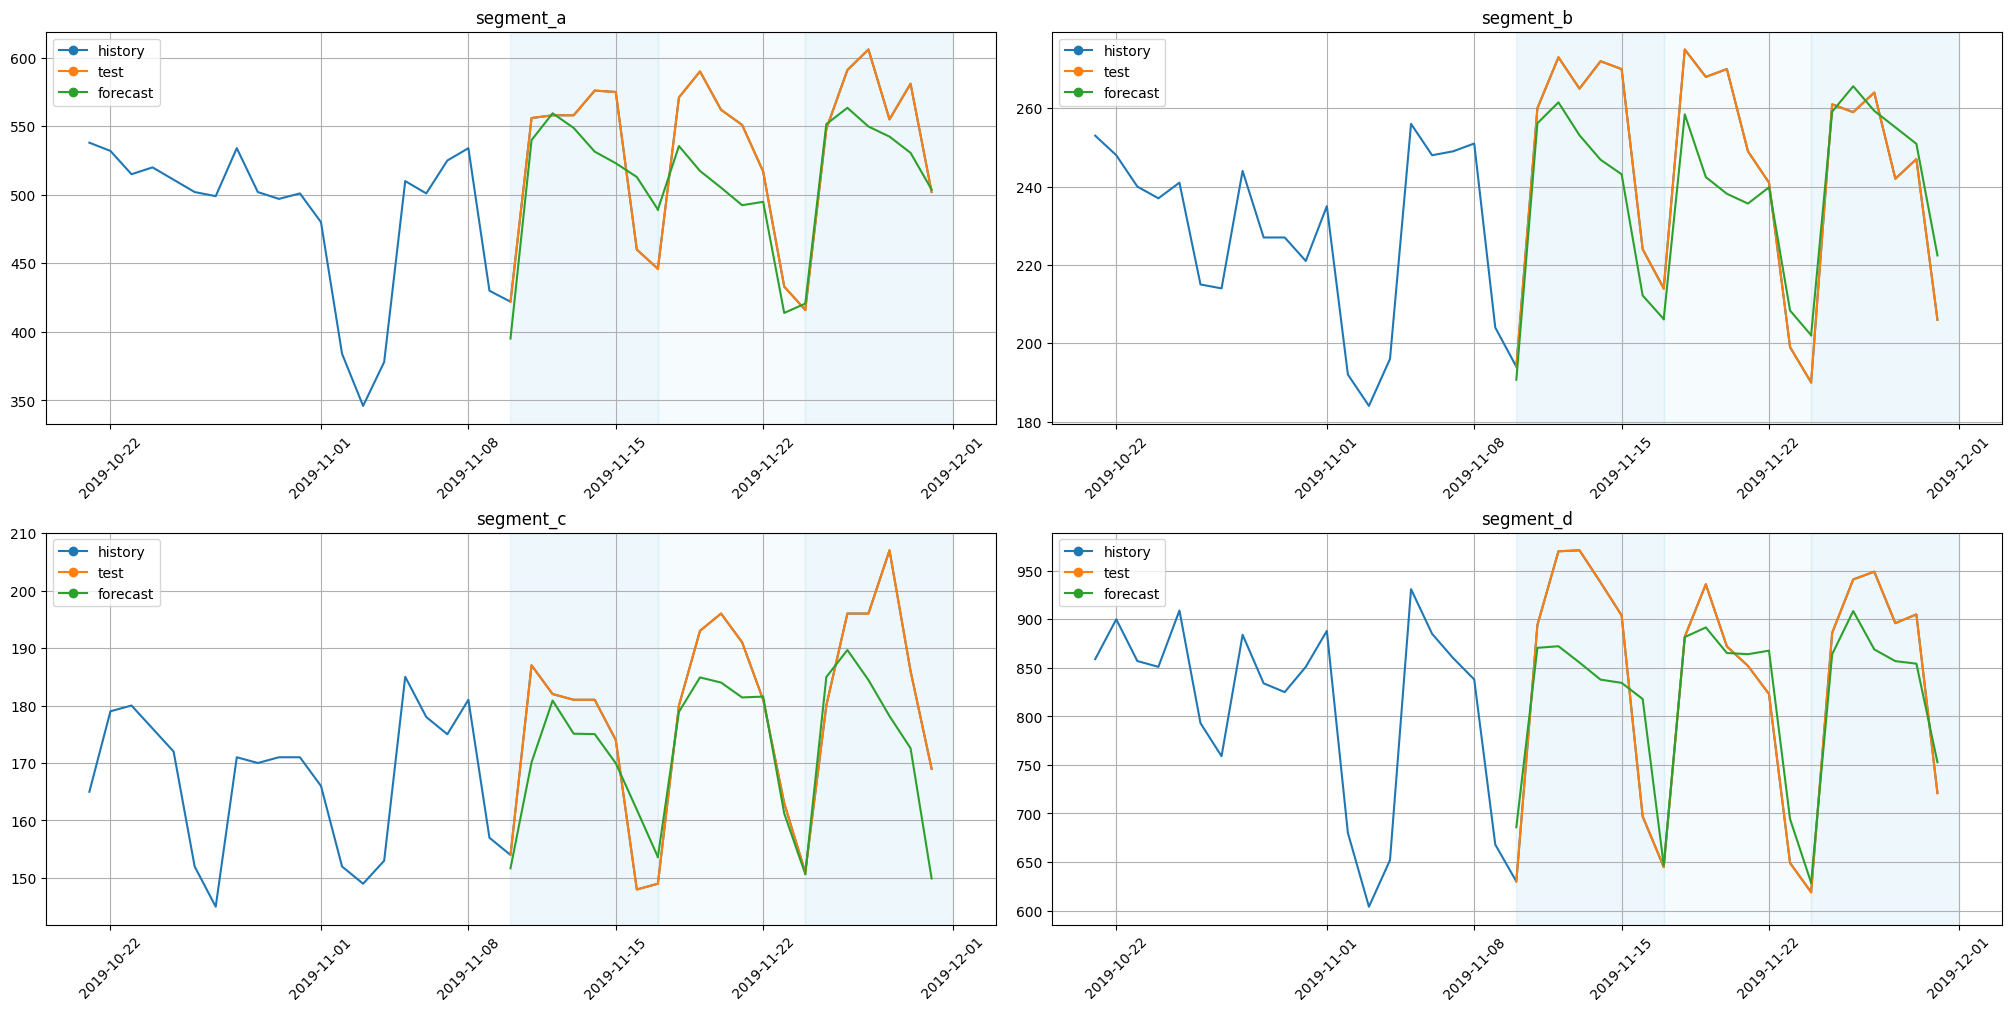

In [27]:
plot_backtest(forecast_tft, ts, history_len=20)

### 3.3 Simple model <a class="anchor" id="section_3_3"></a>

For comparison let's train a much more simpler model.

In [28]:
model_sma = SeasonalMovingAverageModel(window=5, seasonality=7)
linear_trend_transform = LinearTrendTransform(in_column="target")

pipeline_sma = Pipeline(model=model_sma, horizon=HORIZON, transforms=[linear_trend_transform])

In [29]:
metrics_sma, forecast_sma, fold_info_sma = pipeline_sma.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

In [30]:
metrics_sma

,segment,SMAPE,MAPE,MAE,fold_number
0,segment_a,6.343943,6.124296,33.196532,0
0,segment_a,5.346946,5.192455,27.938101,1
0,segment_a,7.510347,7.189999,40.028565,2
3,segment_b,7.178822,6.920176,17.818102,0
3,segment_b,5.672504,5.554555,13.719200,1
3,segment_b,3.327846,3.359712,7.680919,2
1,segment_c,6.430429,6.200580,10.877718,0
1,segment_c,5.947090,5.727531,10.701336,1
1,segment_c,6.186545,5.943679,11.359563,2
2,segment_d,4.707899,4.644170,39.918646,0


In [31]:
score = metrics_sma["SMAPE"].mean()
print(f"Average SMAPE for Seasonal MA: {score:.3f}")

Average SMAPE for Seasonal MA: 5.547


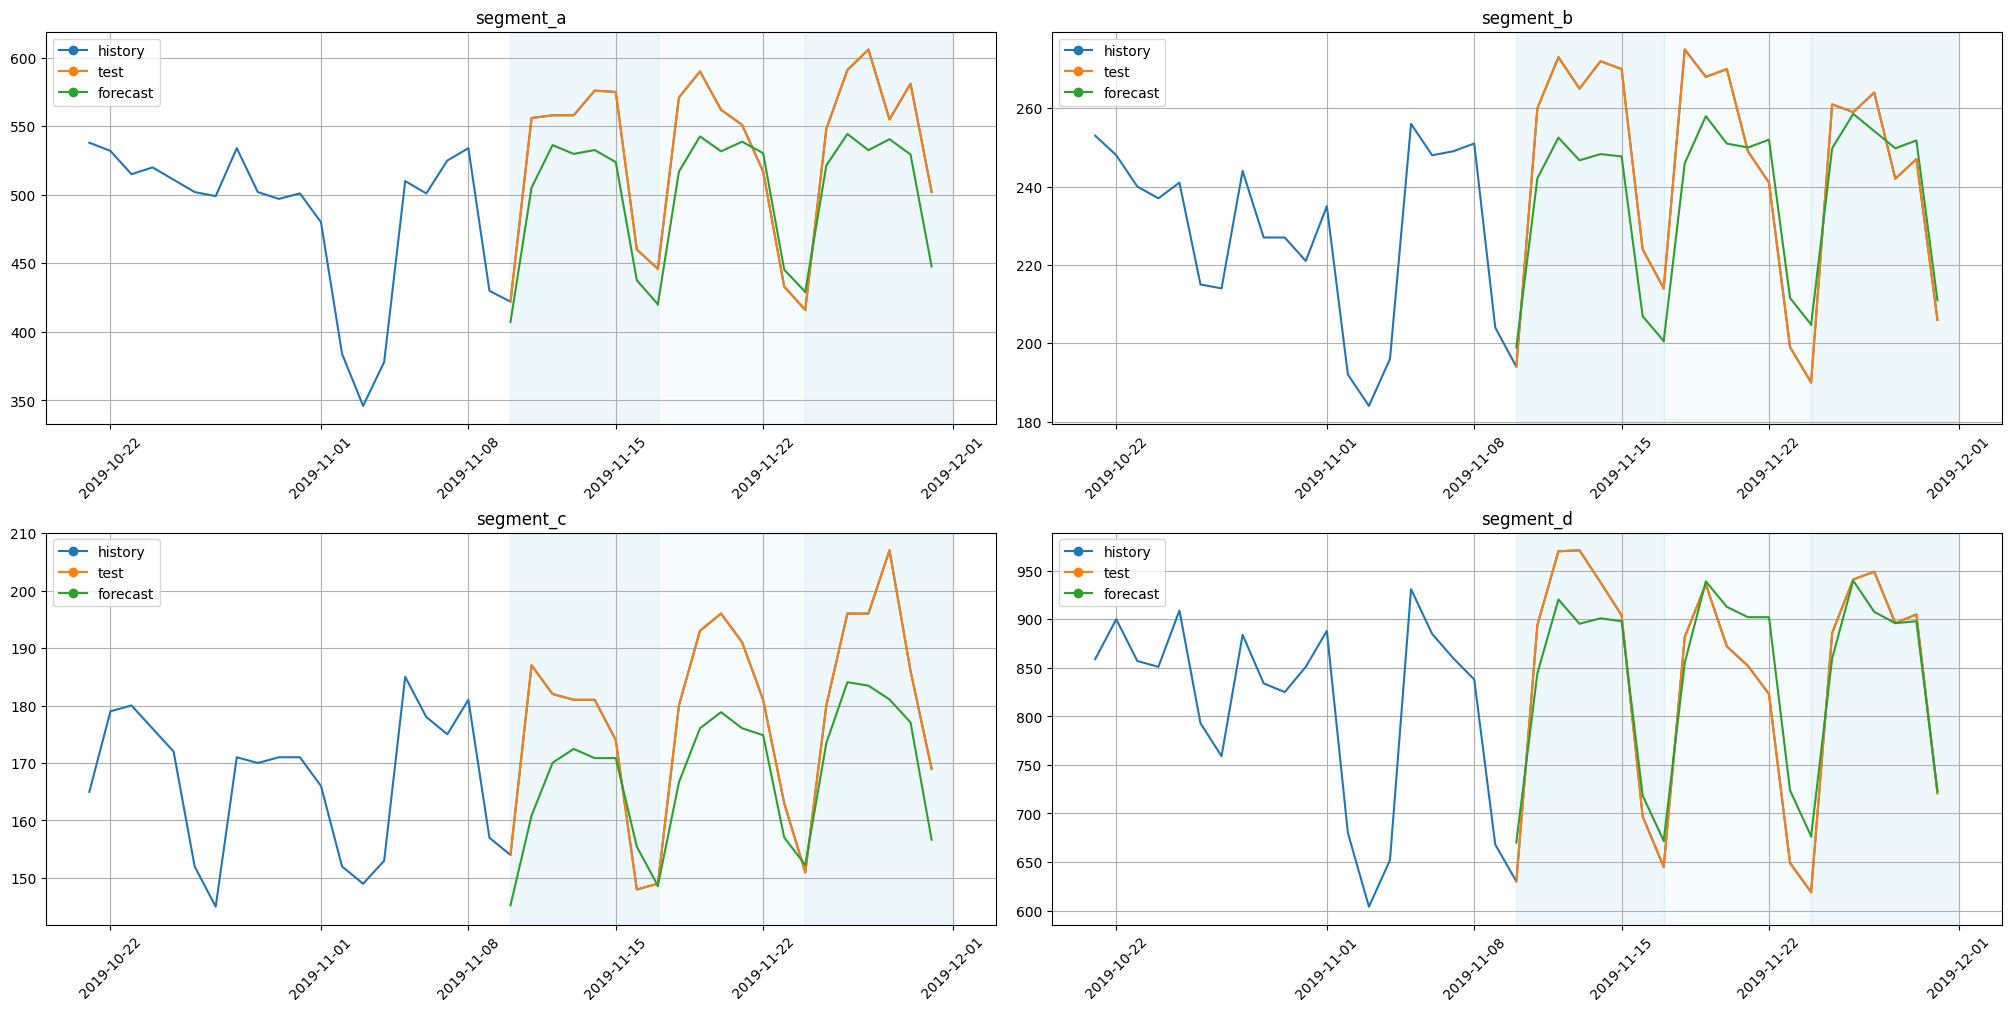

In [32]:
plot_backtest(forecast_sma, ts, history_len=20)

As we can see, neural networks are a bit better in this particular case.

## 4. Etna native deep models<a class="anchor" id="chapter4"></a>

We've used models from pytorch-forecasting above. Now let's talk about etna native implementations of deep models for time series.  
There is small thing to change: we dont need special `PytorchForecastingTransform` now.

### RNNModel
We'll use RNN model based on LSTM cell

In [33]:
from etna.models.nn import RNNModel
from etna.transforms import StandardScalerTransform

In [34]:
model_rnn = RNNModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=11,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[StandardScalerTransform(in_column="target"), transform_lag],
)

In [35]:
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.3s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.0 K 
2 | projection | Linear  | 17    
---------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [36]:
score = metrics_rnn["SMAPE"].mean()
print(f"Average SMAPE for LSTM: {score:.3f}")

Average SMAPE for LSTM: 5.643


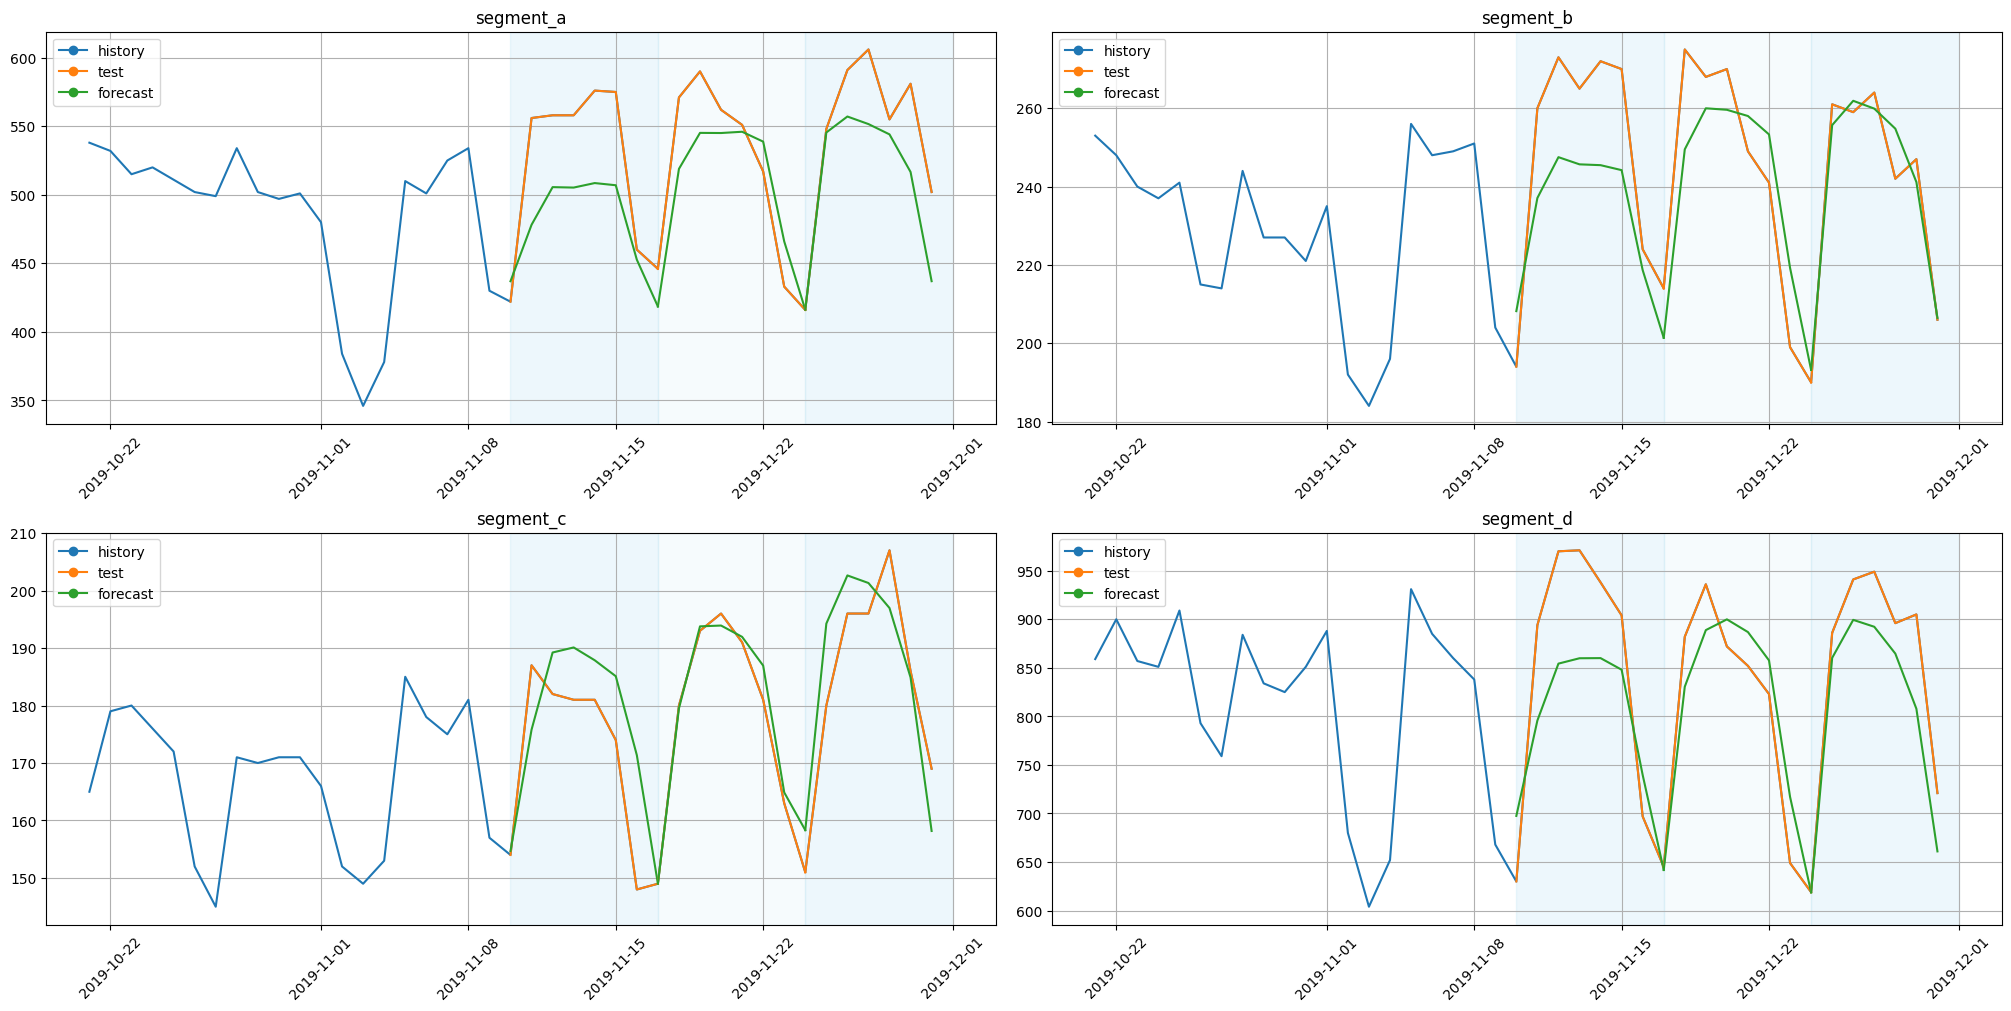

In [37]:
plot_backtest(forecast_rnn, ts, history_len=20)

### Deep State Model

`Deep State Model` works well with multiple similar time-series. It inffers shared patterns from them.

We have to determine the type of seasonality in data (based on data granularity), `SeasonalitySSM` class is responsible for this. In this example, we have daily data, so we use day-of-week (7 seasons) and day-of-month (31 seasons) models. We also set the trend component using the `LevelTrendSSM` class. Also in the model we use time-based features like day-of-week, day-of-month and time independent feature representing the segment of time series.

In [38]:
from etna.models.nn import DeepStateModel
from etna.models.nn.deepstate import CompositeSSM, SeasonalitySSM, LevelTrendSSM
from etna.transforms import StandardScalerTransform, DateFlagsTransform, SegmentEncoderTransform

In [39]:
HORIZON = 7
metrics = [SMAPE(), MAPE(), MAE()]

In [40]:
transforms = [
    SegmentEncoderTransform(),
    StandardScalerTransform(in_column="target"),
    DateFlagsTransform(
        day_number_in_week=True,
        day_number_in_month=True,
        week_number_in_month=False,
        week_number_in_year=False,
        month_number_in_year=False,
        year_number=False,
        is_weekend=False,
        out_column="df",
    ),
]

In [41]:
monthly_smm = SeasonalitySSM(num_seasons=31, timestamp_transform=lambda x: x.day - 1)
weekly_smm = SeasonalitySSM(num_seasons=7, timestamp_transform=lambda x: x.weekday())

In [42]:
model_dsm = DeepStateModel(
    ssm=CompositeSSM(seasonal_ssms=[weekly_smm, monthly_smm], nonseasonal_ssm=LevelTrendSSM()),
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=3,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

pipeline_dsm = Pipeline(
    model=model_dsm,
    horizon=HORIZON,
    transforms=transforms,
)

In [43]:
metrics_dsm, forecast_dsm, fold_info_dsm = pipeline_dsm.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | RNN        | LSTM       | 7.2 K 
1 | projectors | ModuleDict | 5.0 K 
------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | RNN        | LSTM       | 7.2 K 
1 | projectors | ModuleDict | 5.0 K 
------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.3s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | RNN        | LSTM       | 7.2 K 
1 | projectors | ModuleDict | 5.0 K 
------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [44]:
score = metrics_dsm["SMAPE"].mean()
print(f"Average SMAPE for DeepStateModel: {score:.3f}")

Average SMAPE for DeepStateModel: 5.523


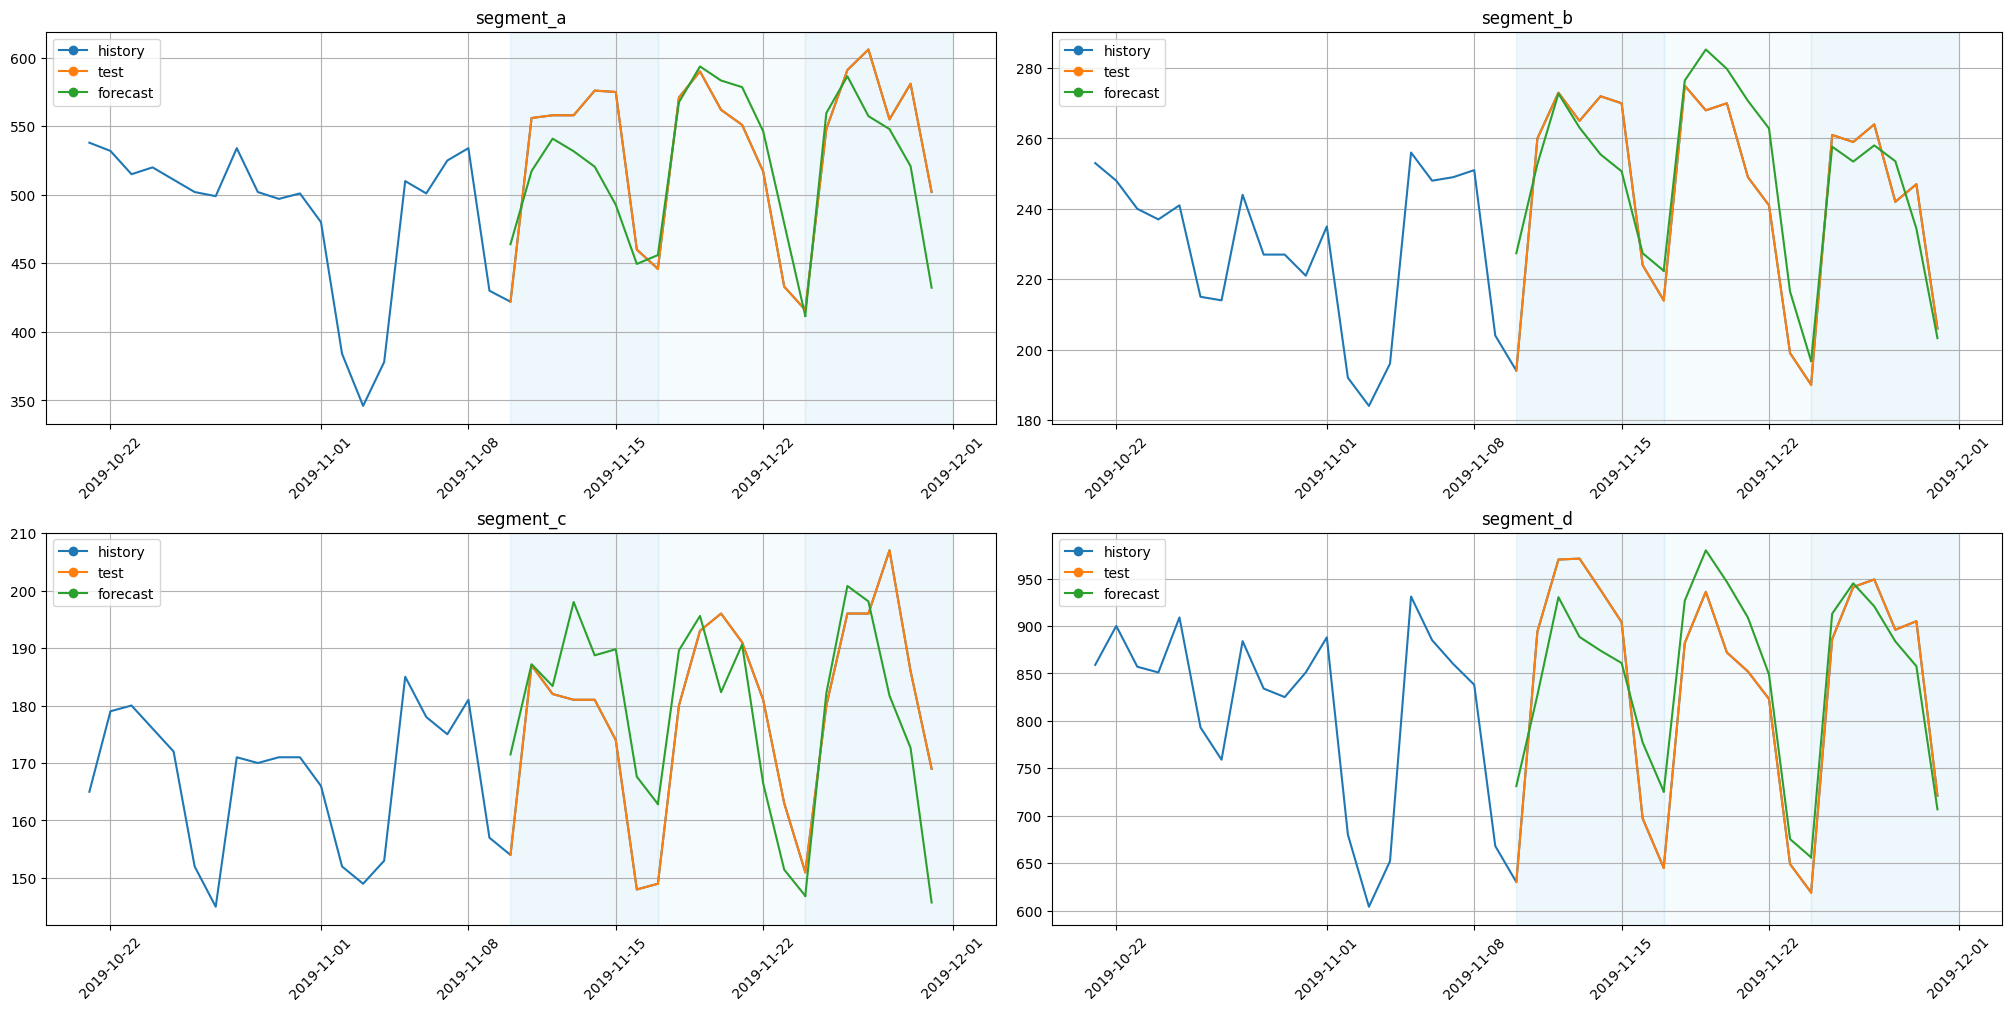

In [45]:
plot_backtest(forecast_dsm, ts, history_len=20)

### N-BEATS Model
This architecture is based on backward and forward residual links and a deep stack of fully connected layers.

There are two types of models in the library. The `NBeatsGenericModel` class implements a generic deep learning model, while the `NBeatsInterpretableModel` is augmented with certain inductive biases to be interpretable (trend and seasonality).

In [46]:
from etna.models.nn import NBeatsGenericModel
from etna.models.nn import NBeatsInterpretableModel

In [47]:
HORIZON = 7
metrics = [SMAPE(), MAPE(), MAE()]

In [87]:
model_nbeats_generic = NBeatsGenericModel(
    input_size=2 * HORIZON,
    output_size=HORIZON,
    loss="mse",
    stacks=30,
    layers=4,
    layer_size=512,
    trainer_params=dict(max_epochs=300),
    lr=1e-3,
)

pipeline_nbeats_generic = Pipeline(
    model=model_nbeats_generic,
    horizon=HORIZON,
    transforms=[],
)

In [88]:
metrics_nbeats_generic, forecast_nbeats_generic, _ = pipeline_nbeats_generic.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NBeats    | 806 K 
1 | loss  | NBeatsMSE | 0     
------------------------------------
806 K     Trainable params
0         Non-trainable params
806 K     Total params
3.226     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NBeats    | 806 K 
1 | loss  | NBeatsMSE | 0     
------------------------------------
806 K     Trainable params
0         Non-trainable params
806 K     Total params
3.226     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   55.6s remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NBeats    | 806 K 
1 | loss  | NBeatsMSE | 0     
------------------------------------
806 K     Trainable params
0         Non-trainable params
806 K     Total params
3.226     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [89]:
score = metrics_nbeats_generic["SMAPE"].mean()
print(f"Average SMAPE for N-BEATS Generic: {score:.3f}")

Average SMAPE for N-BEATS Generic: 7.114


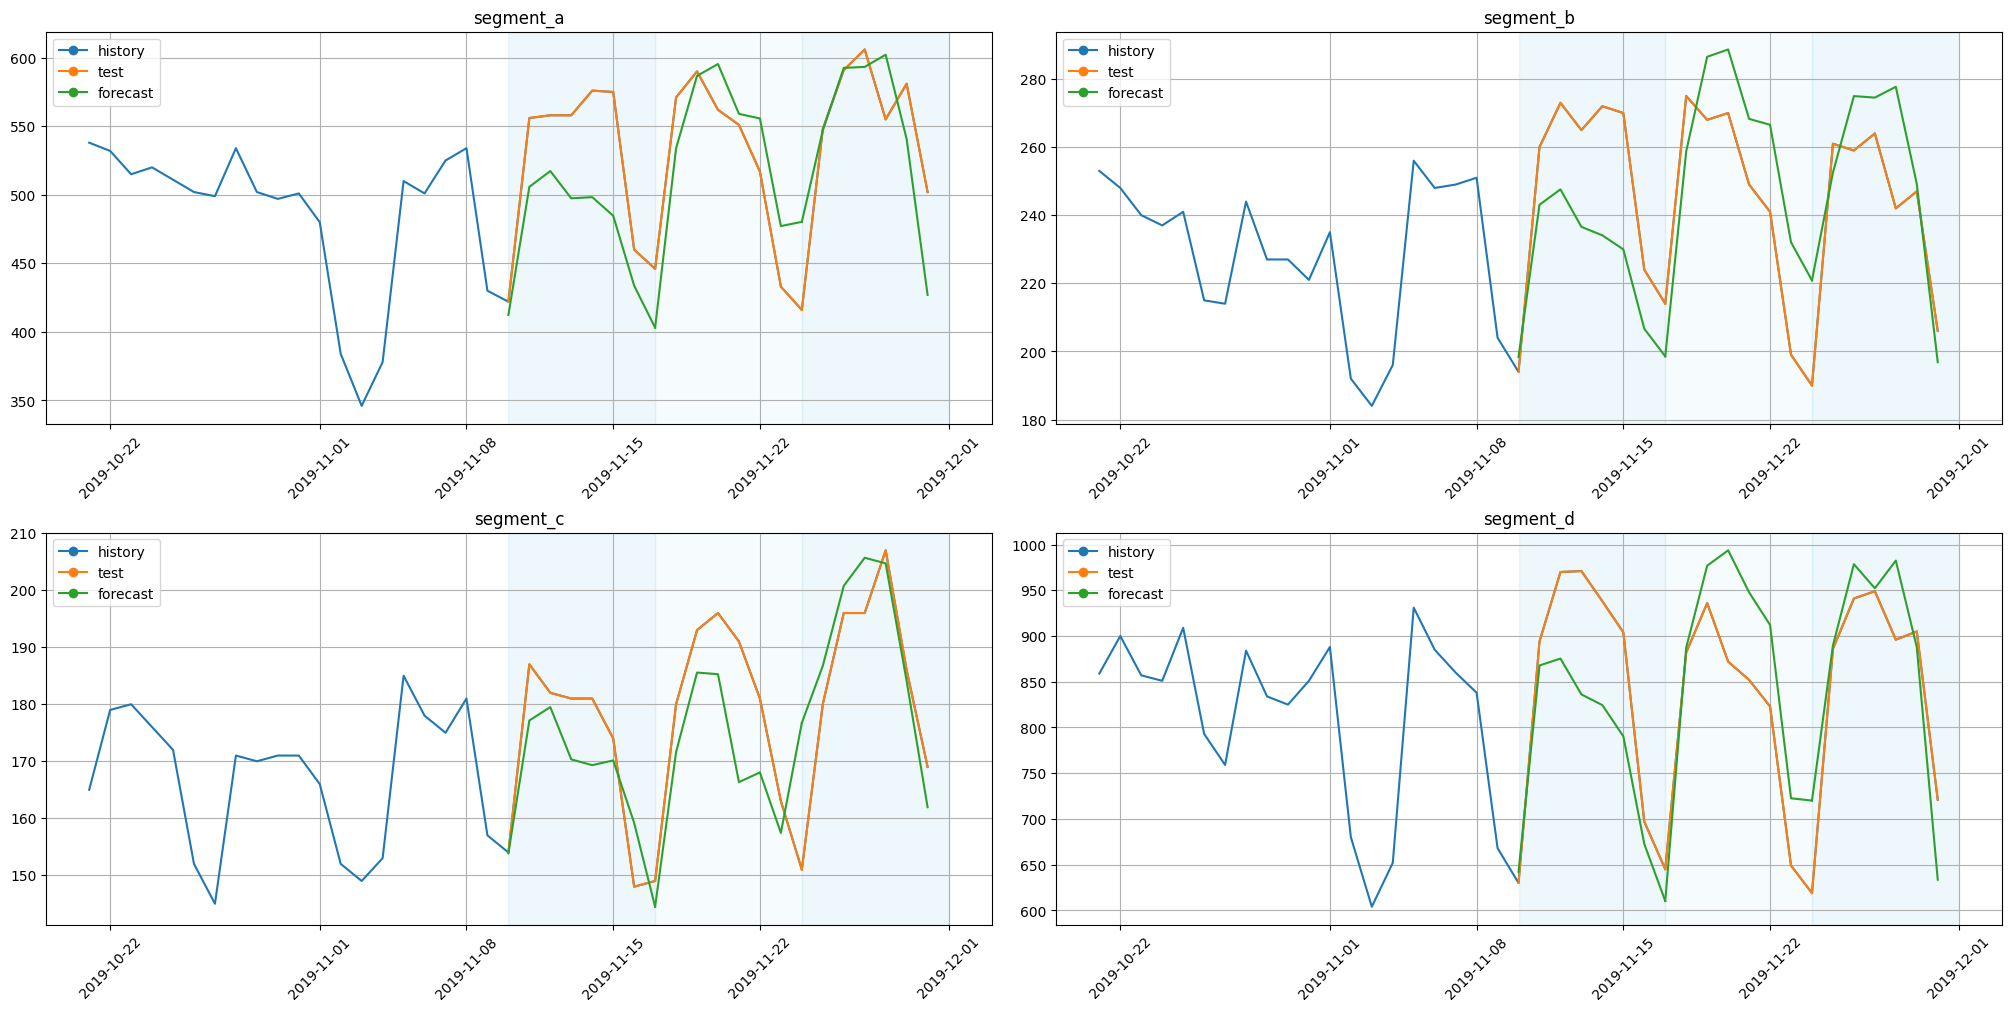

In [90]:
plot_backtest(forecast_nbeats_generic, ts, history_len=20)

In [91]:
model_nbeats_interp = NBeatsInterpretableModel(
    input_size=2 * HORIZON,
    output_size=HORIZON,
    loss="mse",
    trainer_params=dict(max_epochs=300),
    lr=1e-3,
)

pipeline_nbeats_interp = Pipeline(
    model=model_nbeats_interp,
    horizon=HORIZON,
    transforms=[],
)

In [92]:
metrics_nbeats_interp, forecast_nbeats_interp, _ = pipeline_nbeats_interp.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NBeats    | 12.9 M
1 | loss  | NBeatsMSE | 0     
------------------------------------
12.9 M    Trainable params
231       Non-trainable params
12.9 M    Total params
51.422    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NBeats    | 12.9 M
1 | loss  | NBeatsMSE | 0     
------------------------------------
12.9 M    Trainable params
231       Non-trainable params
12.9 M    Total params
51.422    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NBeats    | 12.9 M
1 | loss  | NBeatsMSE | 0     
------------------------------------
12.9 M    Trainable params
231       Non-trainable params
12.9 M    Total params
51.422    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [93]:
score = metrics_nbeats_interp["SMAPE"].mean()
print(f"Average SMAPE for N-BEATS Interpretable: {score:.3f}")

Average SMAPE for N-BEATS Interpretable: 7.997


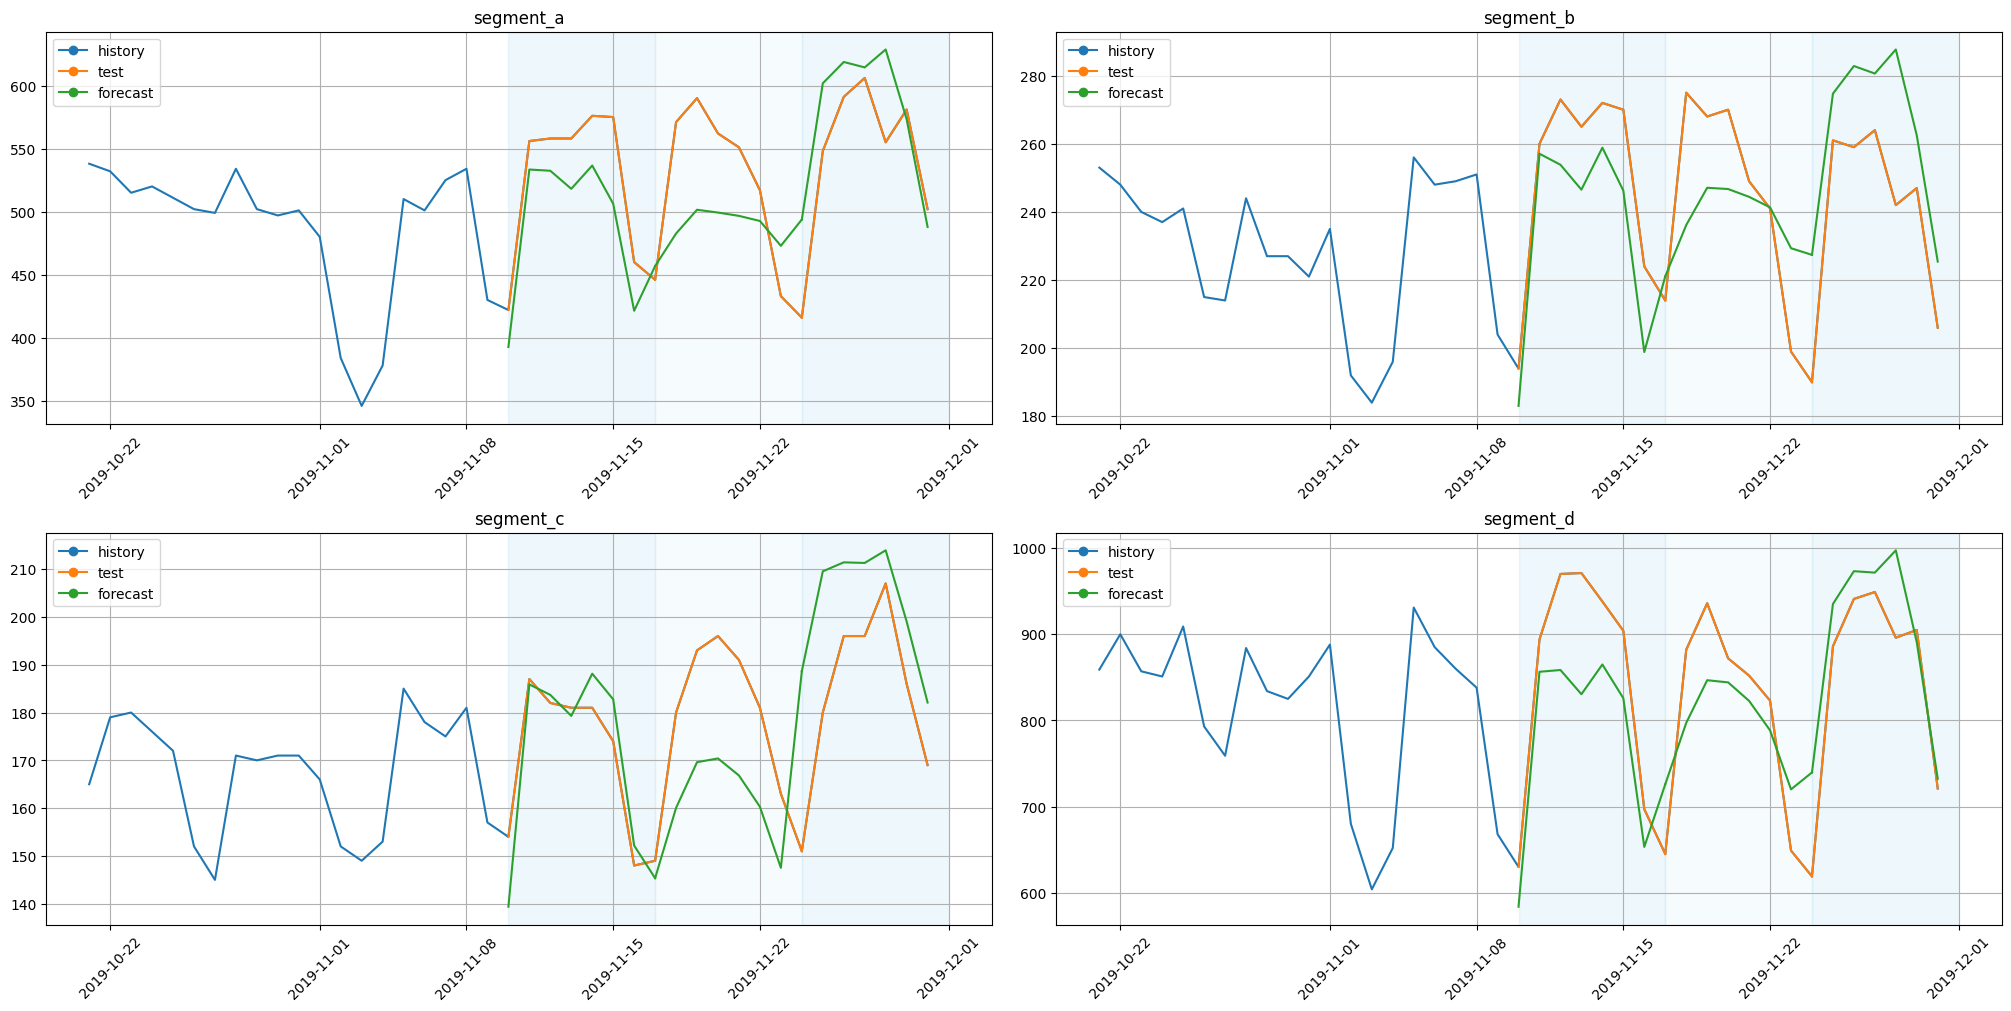

In [94]:
plot_backtest(forecast_nbeats_interp, ts, history_len=20)